# Setup

In [1]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

Conda Environment: rich_clust


In [2]:
from pathlib import Path
import scipy.io
import scipy.sparse
import matplotlib.pyplot as plt
import numpy as np
import sklearn.manifold
import sklearn.cluster
import seaborn as sns
import pandas as pd
import sparse
import cv2

import torch
from kymatio.torch import Scattering2D

import gc
from tqdm.notebook import tqdm
import copy
import time
import random
import functools

In [3]:
params = {
    'dir_github': r'/media/rich/Home_Linux_partition/github_repos/',
}

In [4]:
# dir_github = Path(r'D:\RH_local\github').resolve()
dir_github = Path(params['dir_github']).resolve()

import sys
sys.path.append(str(dir_github))

%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import path_helpers, torch_helpers, featurization, indexing, misc, torch_helpers, plotting_helpers, classification, math_functions, parallel_helpers, clustering, image_processing

%load_ext autoreload
%autoreload 2
from Big_Ugly_ROI_Tracker.multiEps.multiEps_modules import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import paths

In [5]:
# dir_allOuterFolders = Path(r"D:\RH_local\data\scanimage data\round 5 experiments\mouse 2_6").resolve()
dir_allOuterFolders = Path(r"/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10").resolve()

folders_allSessions = path_helpers.get_dir_contents(dir_allOuterFolders)[0]

folders_toUse = folders_allSessions
# folders_toUse = list(map(folders_allSessions.__getitem__, [np.arange(1,9, dtype=np.int32)]))


# dir_allS2pFolders = [dir_allOuterFolders / folder / 'exp' / 'suite2p' / 'plane0' for folder in folders_toUse]
dir_allS2pFolders = [dir_allOuterFolders / folder for folder in folders_toUse]

pathSuffixToStat = "plane1/stat.npy"
pathSuffixToOps = "plane1/ops.npy"

paths_allStat = [path / pathSuffixToStat for path in dir_allS2pFolders]
paths_allOps  = [path / pathSuffixToOps for path in dir_allS2pFolders]

display(folders_allSessions)
display(folders_toUse)
display(dir_allS2pFolders)
display(paths_allStat)

['D1',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9']

['D1',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9']

[PosixPath('/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D1'),
 PosixPath('/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D10'),
 PosixPath('/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D11'),
 PosixPath('/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D12'),
 PosixPath('/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D13'),
 PosixPath('/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D14'),
 PosixPath('/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D2'),
 PosixPath('/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D3'),
 PosixPath('/media/

[PosixPath('/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D1/plane1/stat.npy'),
 PosixPath('/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D10/plane1/stat.npy'),
 PosixPath('/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D11/plane1/stat.npy'),
 PosixPath('/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D12/plane1/stat.npy'),
 PosixPath('/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D13/plane1/stat.npy'),
 PosixPath('/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D14/plane1/stat.npy'),
 PosixPath('/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D2/plane1/stat.npy'),
 PosixPath('/media/rich/bigSS

In [6]:
pref_use_NN_distances = True

## NN fileNames
fileName_NN_pth = 'ResNet18_simCLR_model_202112078_EOD_transfmod=efficient.pth' # name of pth file in dir_NNmodels directory
fileName_NN_py  = 'ResNet18_simCLR_model_202112078_EOD_transfmod=efficient' # EXCLUDE THE .PY AT THE END. name of py file in dir_NNmodels directory.

## Directories of Classifier stuff
dir_GRC_repo = dir_github / 'GCaMP_ROI_classifier'
dir_GRC_EndUser = dir_GRC_repo / 'End_User'
dir_NNmodels = dir_GRC_EndUser / 'simclr-models'
dir_GRC_util = dir_GRC_repo / 'new_stuff'

## Paths to NN and LR classifiers
path_NN_pth = dir_NNmodels / fileName_NN_pth
path_NN_py = dir_NNmodels / fileName_NN_py

display(path_NN_pth)
display(path_NN_py)

PosixPath('/media/rich/Home_Linux_partition/github_repos/GCaMP_ROI_classifier/End_User/simclr-models/ResNet18_simCLR_model_202112078_EOD_transfmod=efficient.pth')

PosixPath('/media/rich/Home_Linux_partition/github_repos/GCaMP_ROI_classifier/End_User/simclr-models/ResNet18_simCLR_model_202112078_EOD_transfmod=efficient')

In [7]:
import sys
sys.path.append(str(dir_NNmodels))
sys.path.append(str(dir_github))
sys.path.append(str(dir_GRC_util))
sys.path.append(str(dir_GRC_EndUser))

# %load_ext autoreload
# %autoreload 2
import util
import simclr_helpers

# Settings (global)

In [8]:
use_GPU = True

# Alignment

In [9]:
## select and enhance images for registration

ops = [np.load(path, allow_pickle=True)[()] for path in paths_allOps]

meanIms = [ops[ii]['meanImgE'] for ii in range(len(ops))]
meanIms = apply_CLAHE(meanIms, clipLimit=40)

frame_height = meanIms[0].shape[0]
frame_width = meanIms[0].shape[1]

In [10]:
# %matplotlib notebook
# display_toggle_image_stack(meanIms, clim=None)

## Make spatial_footprints
- Make a lazy list of all the spatial_footprints
- Convert spatial footprints to a sparse array (`ROIs_aligned`)

In [11]:
sf_all = import_and_convert_to_CellReg_spatialFootprints(paths_allStat, frame_height=frame_height, frame_width=frame_width, dtype=np.float32)

ROIs_aligned, FOVs_aligned, flows = register_ROIs(meanIms[0], meanIms, sf_all, return_sparse=True, normalize=True)

n_roi_per_sesh = [sfs.shape[0] for sfs in ROIs_aligned]
n_roi_all = np.sum(n_roi_per_sesh)
n_sessions = len(ROIs_aligned)

In [12]:
## remove NaNs from ROIs
for ii in range(len(ROIs_aligned)):
    ROIs_aligned[ii].data[np.isnan(ROIs_aligned[ii].data)] = 0

Check to make sure the FOVs look aligned

In [13]:
# display_toggle_image_stack(FOVs_aligned, clim=None)

In [14]:
# display_toggle_image_stack([rois.multiply( rois.max(1).power(-1) ).sum(0).reshape(frame_height, frame_width) for rois in ROIs_aligned], clim=None)

In [15]:
# display_toggle_2channel_image_stack(flows, clim=(-20,20))

## Blur ROIs (optional)

devices available: [_CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24234MB, multi_processor_count=82)]
Using device: 'cuda:0': _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24234MB, multi_processor_count=82)


  0%|          | 0/14 [00:00<?, ?it/s]

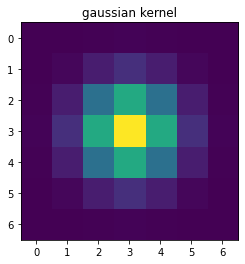

In [16]:
## only needed if convolving ROIs and/or using neural net outputs for distance matrix
pref_blurROIs = True
DEVICE_blur = torch_helpers.set_device(use_GPU=use_GPU) # define torch device to use. either 'cpu', 'cuda', number, or something else. See torch_helpers.set_device()

if pref_blurROIs == True:
    kernel_size = 7 # Edge length of kernel image. Make odd number.
    kernel_sigma = 1 # sigma of 2D gaussian kernel
    kernel = featurization.gaussian_kernel_2D(center=(kernel_size//2, kernel_size//2), image_size=(kernel_size, kernel_size), sig=kernel_sigma)
    kernel = kernel / kernel.sum()

    ## show the kernel
    plt.figure()
    plt.imshow(kernel);
    plt.title('gaussian kernel')
    
    ROIs_aligned_blur = [batch_2D_sparse_convolution(
        images=rois, 
        kernel=kernel,
        image_shape=(frame_height, frame_width),
        num_batches=10,
        device=DEVICE_blur,
    ) for rois in tqdm(ROIs_aligned)]

In [69]:
# display_toggle_image_stack([ROIs.sum(0).reshape(frame_height, frame_width) for ROIs in ROIs_aligned_blur]) if pref_blurROIs else None

## Neural network embedding distances

In [18]:
sf_all_cropped = util.import_multiple_stat_files(
    paths_statFiles=paths_allStat, 
#     dir_statFiles=None,
#     fileNames_statFiles=None,
    out_height_width=[36,36], 
    max_footprint_width=441, 
    plot_pref=False
)

In [19]:
device_model = torch_helpers.set_device(use_GPU=use_GPU)

model, model_module = import_pth_model(path_NN_pth, fileName_NN_py)

data = np.concatenate(sf_all_cropped, axis=0)

if pref_use_NN_distances:
    # Create Data Sets / Data Loaders
    dataset, dataloader = model_module.get_dataset_dataloader(data, batch_size=64, device=device_model) ## TODO: Troubleshoot the runtime on this

    # Get Model Latents
    latents = simclr_helpers.dataloader_to_latents(dataloader, model.to(device_model), DEVICE=device_model)
    
else:
    latents = None

devices available: [_CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24234MB, multi_processor_count=82)]
Using device: 'cuda:0': _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24234MB, multi_processor_count=82)


/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/580 [00:00<?, ?it/s]

/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %250 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)


In [20]:
del model

gc.collect()

torch.cuda.empty_cache()

## Scattering wavelet embedding distances

In [21]:
device_model = torch_helpers.set_device(use_GPU=use_GPU)

scattering = Scattering2D(J=2, L=8, shape=sf_all_cropped[0].shape[-2:])
if use_GPU:
    scattering = scattering.cuda()

latents_swt = torch.cat([get_latents_swt(sfs, scattering, device_model).cpu() for sfs in sf_all_cropped], axis=0)

devices available: [_CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24234MB, multi_processor_count=82)]
Using device: 'cuda:0': _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24234MB, multi_processor_count=82)


## Make blocks

In [22]:
frame_height=FOVs_aligned[0].shape[0]
frame_width=FOVs_aligned[0].shape[1]
block_height=75
block_width=75
overlapping_width_Multiplier=0.0
outer_block_height=100
outer_block_width=100
clamp_outer_block_to_frame=True

inner_blocks, outer_blocks, centers = make_block_batches(
    frame_height=frame_height,
    frame_width=frame_width,
    block_height=block_height,
    block_width=block_width,
    overlapping_width_Multiplier=overlapping_width_Multiplier,
    outer_block_height=outer_block_height,
    outer_block_width=outer_block_width,
    clamp_outer_block_to_frame=clamp_outer_block_to_frame
)
n_blocks = len(inner_blocks)
# display(inner_blocks)
# display(outer_blocks)
print(f'number of blocks: {n_blocks}')

number of blocks: 70


In [23]:
# visualize_blocks(inner_blocks, outer_blocks, frame_height=frame_height, frame_width=frame_width)

## t-SNE parameters

In [24]:
NN = sklearn.neighbors.NearestNeighbors(
#         n_neighbors=100,  ## currently using min(sf_block_flat.shape[0], max_n_neighbors)
#     radius=1.0, 
    algorithm='auto',
    leaf_size=30, 
    metric='manhattan',
    p=1,
#     metric_params=None, 
    n_jobs=-1
)

method_tsne = 'barnes_hut' if len(sf_all) >= 4 else 'exact'
# method_tsne = 'exact'  # use if you are looking for clusters with 3 or fewer samples in them
print(f'Method used for t-SNE: {method_tsne}')

tsne = sklearn.manifold.TSNE(
    n_components=2,
#     perplexity=30.0,
    early_exaggeration=12.0,
    learning_rate='auto',
#     learning_rate=,
    n_iter=1000,
    n_iter_without_progress=300,
    min_grad_norm=1e-07,
    metric='precomputed',
    init='random',
    verbose=0,
    random_state=None,
#     method='barnes_hut',
#     method='exact',
#     method=method_tsne,
    angle=0.01,
    n_jobs=-1,
    square_distances=True,
)

Method used for t-SNE: barnes_hut


In [25]:
#### IMPORTANT PARAMETER: K-NEAREST NEIGHBORS ####
## Lower this to improve speed, but sacrifice some quality. 
## Choose a number that is > ~ the largest number of ROIs you think a single ROI might have any overlap with.
## For most datasets, values around 200 should give high quality results.
## Max value is 1023.
## Value must be > 3*perplexity.

max_n_neighbors = 100
max_perplexity = 10

##################################################


####### Other Parameters #######

## This parameter determines how 'binary'-looking masks are
## Small values = more binary. Large values weight bright pixels more
## mask_scaled = mask ** mask_power
mask_power = 0.3

## Embed ROIs in t-SNE space

In [26]:
sfs = scipy.sparse.vstack(ROIs_aligned_blur)
sfs = sfs.power(0.3)
sfs = sfs.multiply( 0.5 / sfs.sum(1))
sfs = scipy.sparse.csr_matrix(sfs)

In [27]:
sfs.shape

(37061, 360960)

In [28]:
distances_IOU = sklearn.neighbors.NearestNeighbors(
        algorithm='brute',
        leaf_size=30, 
        metric='manhattan',
        p=1,
    #     metric_params=None, 
        n_jobs=-1
    ).fit(sfs).kneighbors_graph(
        sfs,
        n_neighbors=sfs.shape[0],
        mode='distance'
    )

In [29]:
distances_NN = torch.cdist(latents, latents, p=2)

In [30]:
distances_swt = torch.cdist(latents_swt, latents_swt, p=2)

In [31]:
s_IOU = 1 - distances_IOU.todense()
s_IOU[s_IOU < 0] = 0
s_IOU[range(s_IOU.shape[0]), range(s_IOU.shape[0])] = 0
s_IOU = torch.as_tensor(s_IOU, dtype=torch.float32)

In [32]:
s_NN = 1 / (distances_NN / distances_NN.max())
s_NN[s_NN < 0] = 0
s_NN[range(s_NN.shape[0]), range(s_NN.shape[0])] = 0

In [33]:
s_swt = 1 / (distances_swt / distances_swt.max())
s_swt[s_swt < 0] = 0
s_swt[range(s_swt.shape[0]), range(s_swt.shape[0])] = 0

In [278]:
session_bool = torch.as_tensor(np.vstack([np.array([indexing.idx2bool(i_sesh, length=n_sessions)]*sesh.shape[0]) for i_sesh, sesh in enumerate(ROIs_aligned)]), device='cpu', dtype=torch.float32)
s_sesh = torch.logical_not((session_bool @ session_bool.T).type(torch.bool))

In [303]:
s_conj = s_IOU * s_NN * s_swt * s_sesh

In [306]:
s_conj[s_conj < 1e-5] = 0

In [307]:
s_conj.to_sparse()

tensor(indices=tensor([[    0,     0,     0,  ..., 37060, 37060, 37060],
                       [ 2453,  2863,  2905,  ..., 32274, 32341, 32451]]),
       values=tensor([4.6143e-03, 1.6777e+01, 5.0014e+00,  ...,
                      1.0217e-05, 1.5649e-05, 1.5570e-01]),
       size=(37061, 37061), nnz=4364826, layout=torch.sparse_coo)

In [308]:
d_conj = 1 / s_conj

In [309]:
d_conj[np.isinf(d_conj).type(torch.bool)] = 0

In [310]:
d_conj = torch.maximum( d_conj, d_conj.T )

In [311]:
d_conj = scipy.sparse.csr_matrix(d_conj.numpy())

In [312]:
# d = d_conj.todense()
d = distances_IOU.todense()

link_methods = ['single', 'complete', 'ward', 'average']
# link_methods = ['average']
links = {method : scipy.cluster.hierarchy.linkage(scipy.spatial.distance.squareform(d), method=method) for method in tqdm(link_methods)}

  0%|          | 0/4 [00:00<?, ?it/s]

In [313]:
def display_clustering_widget(
    embeddings, 
    min_samples, 
    max_samples=None,
    min_slider=0.01,
    max_slider=5, 
    start_slider=1.0,
    single_color=False,
    ):

    from ipywidgets import interact, widgets
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib as mpl

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    sc = ax.scatter(embeddings[:,0], embeddings[:,1], s=10)
    # sc = ax.scatter(embeddings2[:,0], embeddings2[:,1], embeddings2[:,2], s=15)

    def get_val_counts(vals):
        vals_unique = np.unique(vals)
        vals_counts = np.zeros_like(vals, dtype=np.int64)
        for ii, val in enumerate(vals_unique):
            vals_counts[vals==val] = np.sum(vals==val)
        return vals_counts
    def update(t=1):
        t_toUse = t/10000
        
#         # Compute DBSCAN
#         db = sklearn.cluster.DBSCAN(
#             eps=eps_toUse,
#             min_samples=min_samples, 
#     #         metric='manhattan',
#             metric_params=None, 
#             algorithm='auto',
#             leaf_size=30, 
#             p=2, 
#             n_jobs=-1
#         ).fit(embeddings)

#         labels = db.labels_
#     #     labels = db.labels_ - db.labels_.min()
    
        labels = scipy.cluster.hierarchy.fcluster(links['average'], t=t_toUse, criterion='distance')
        
        if max_samples is not None:
            labels[get_val_counts(labels) > max_samples] = -1

        if single_color:
            cmap = rand_cmap(2, verbose=False)
        else:
            cmap = rand_cmap(len(np.unique(labels)), verbose=False)

        if len(np.unique(labels)) == 1:
            print('Eps value gives one big cluster. Adjust')
        else:
            sc.set_color(cmap(squeeze_integers(labels)+1))

            fig.canvas.draw_idle()
            ax.set_title(f'eps={round(t_toUse,3)}, n_clusters={len(np.unique(labels))}')
            print(np.unique(labels))

    interact(update, t=widgets.IntSlider(min=min_slider, max=max_slider, step=1, value=start_slider));
#     interact(update, t=widgets.IntSlider(min=0, max=200, step=1, value=1));
    

rand_cmap = plotting_helpers.rand_cmap
squeeze_integers = classification.squeeze_integers

In [314]:
cmap = plotting_helpers.rand_cmap(nlabels=d.shape[0], verbose=False)

# c_labels = cmap(tuple(torch.linspace(0.,1., len(labels))))

In [315]:
import scipy.ndimage

In [316]:
stats = [np.load(path_stat, allow_pickle=True) for path_stat in paths_allStat]

In [317]:
meds = np.concatenate([np.array([stat[jj]['med'] for jj in range(len(stat))]) for stat in stats])

<IPython.core.display.Javascript object>


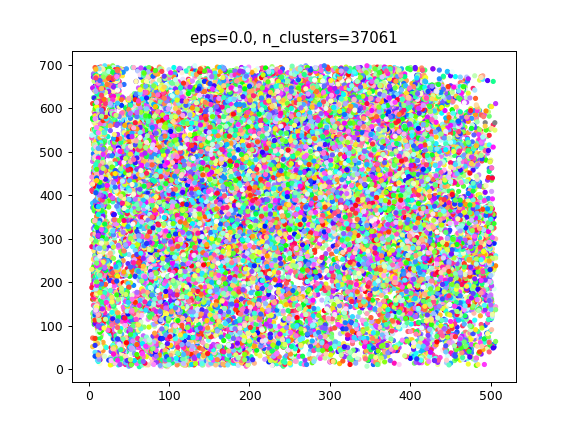

interactive(children=(IntSlider(value=1, description='t', max=10000), Output()), _dom_classes=('widget-interac…

In [318]:
%matplotlib notebook

display_clustering_widget(
    embeddings=meds, 
    min_samples=2, 
    max_samples=None,
    min_slider=0,
    max_slider=10000, 
    start_slider=1,
    single_color=False,
    )

In [319]:
sweep_t_vals = math_functions.bounded_logspace(0.3, 0.95, 200)

In [320]:
def _labels_to_idx(labels):
#     return {label: np.where(labels==label)[0] for label in np.unique(labels)}
    return [np.where(labels==label)[0] for label in np.unique(labels)]

def _labels_to_bool(labels):
#     return {label: np.where(labels==label)[0] for label in np.unique(labels)}
    return np.array([labels==label for label in np.unique(labels)])

def _freq_of_values(vals):
    u = np.unique(vals)
    f = np.array([np.sum(vals==unique) for unique in u])
    return np.array([f[u==val][0] for val in vals])




cluster_idx = []
for ii, t in tqdm(enumerate(sweep_t_vals)):
    [cluster_idx.append(scipy.sparse.csr_matrix(_labels_to_bool(scipy.cluster.hierarchy.fcluster(links[method], t=t, criterion='distance')))) for method in link_methods]
cluster_idx = scipy.sparse.vstack(cluster_idx)

0it [00:00, ?it/s]

In [340]:
def hash_matrix(x):
    y = np.array(np.packbits(x.todense(), axis=1))
    return np.array([hash(tuple(vec)) for vec in y])

In [342]:
# batch_size = 1000
# l = cluster_idx.shape[0]
# clusterHashes = np.concatenate([hash_matrix(batch) for batch in tqdm(indexing.make_batches(cluster_idx[:l], batch_size=batch_size, length=l), total=l/batch_size)], axis=0).shape

clusterHashes = np.concatenate(parallel_helpers.multiprocessing(hash_matrix, indexing.make_batches(cluster_idx, batch_size=100, length=cluster_idx.shape[0]), workers=32), axis=0)

In [343]:
# clusterHashes_block = [hash(tuple(vec)) for vec in cluster_idx]
# u, idx, c = np.unique(
#     ar=clusterHashes_block,
#     return_index=True,
#     return_counts=True,
# )

u, idx, c = np.unique(
    ar=clusterHashes,
    return_index=True,
    return_counts=True,
)

# clusters_idx_unique, clusters_idx_unique_freq = np.unique(cluster_idx, axis=0, return_counts=True)

clusters_idx_unique = cluster_idx[idx]
clusters_idx_unique_freq = c

In [344]:
min_samples = 2
max_samples = n_sessions

# sizes_clusters_raw = np.array([len(idx) for idx in clusters_idx_unique], dtype=np.int64)
sizes_clusters_raw = clusters_idx_unique.sum(1)
# print(clusters_idx_unique)

bool_tooSmall = (sizes_clusters_raw < min_samples).astype(np.bool8)
bool_tooBig = (sizes_clusters_raw > max_samples).astype(np.bool8)

idx_toDelete = np.array(bool_tooSmall + bool_tooBig).squeeze()

## remove clusters with too few samples
clusters_idx_unique = clusters_idx_unique[np.logical_not(idx_toDelete),:]
clusters_idx_unique_freq = clusters_idx_unique_freq[np.logical_not(idx_toDelete)]

# clusters_idx_unique = np.delete(clusters_idx_unique, idx_toDelete)
# clusters_idx_unique_freq = np.delete(clusters_idx_unique_freq, idx_toDelete)

In [345]:
h_raw = torch.stack([torch.as_tensor(indexing.idx2bool(idx.toarray().squeeze(), length=n_roi_all), dtype=torch.float32) for idx in clusters_idx_unique], dim=0).T.type(torch.bool)

In [375]:
c_score = clustering.cluster_similarity_score(s_conj**2, h_raw.type(torch.float32), method_in='mean', method_out='mean')

<IPython.core.display.Javascript object>


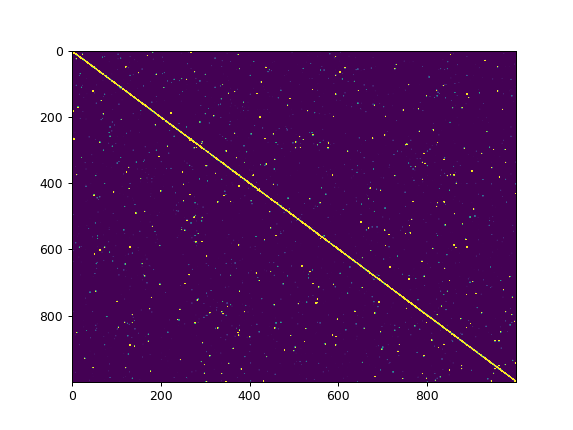

In [376]:
plt.figure()
plt.imshow(
#     c_score[:200, :200]*torch.logical_not(torch.eye(200)), 
    c_score[:1000, :1000], 
    aspect='auto',
    vmax=10
)

In [358]:
c_sil = clustering.cluster_silhouette_score(s_conj, h_raw)

In [359]:
c_sil_norm = math_functions.generalised_logistic_function(torch.log(c_sil), mu=0.5)**3

In [363]:
c_redundant = ( (torch.einsum('ab, ac, bd -> cd', torch.eye(h_raw.shape[0], dtype=torch.float32), h_raw.type(torch.float32), h_raw.type(torch.float32))>0) * (torch.logical_not(torch.eye(h_raw.shape[1]))) ).type(torch.bool)

In [364]:
w_raw = ((h_raw.cpu().sum(0) / n_sessions)**3) * (c_sil_norm.cpu()**1) * (clusters_idx_unique_freq / clusters_idx_unique_freq.max())**1

<IPython.core.display.Javascript object>


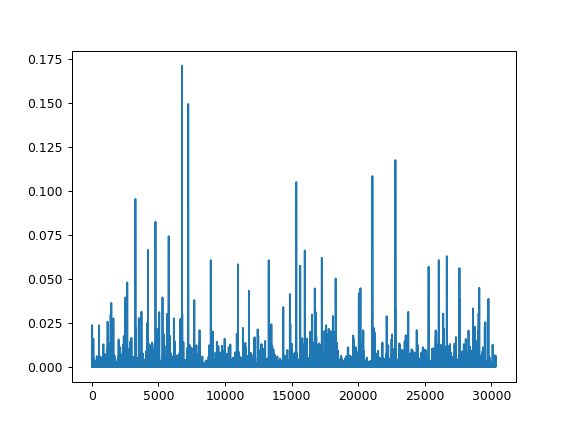

In [365]:
plt.figure()
plt.plot(w_raw.cpu())
# plt.ylim([0,1.1])

<IPython.core.display.Javascript object>


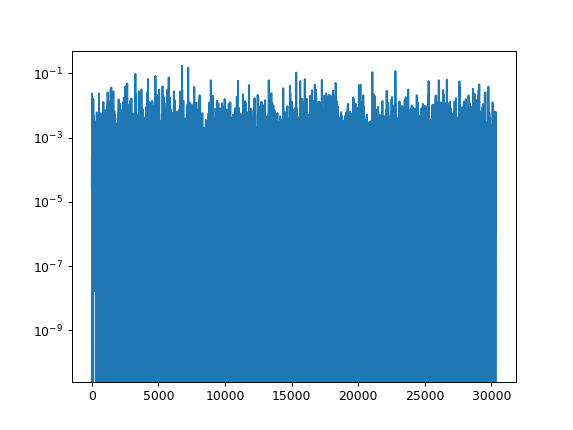

In [366]:
plt.figure()
plt.plot(w_raw.cpu())
plt.yscale('log')
# plt.ylim([0,1.1])

In [379]:
idx_c_good = (w_raw>1e-4)
idx_c_good.sum() / w_raw.shape[0]

tensor(0.3184)

In [380]:
DEVICE = 'cuda:0'

# c = (c_max*1 + c_mean*1)/2 + c_redundant*0
c = copy.copy(c_score)[idx_c_good][:,idx_c_good]

# c = c_max + c_redundant*1
# c = c_local*1
# c = c_sum
# c = c_mean
# c = c_local
# c = c_sum + c_redundant*2

h = copy.copy(h_raw)[:, idx_c_good]

w = w_raw[idx_c_good]

crc = clustering.Constrained_rich_clustering(
    c,
    h,
    w,
    device=DEVICE,
    m_init=(torch.ones(c.shape[0])*-5 + torch.rand(c.shape[0])*1).type(torch.float32),
    optimizer_partial=functools.partial(torch.optim.Adam, lr=1e-1, betas=(0.9, 0.900)),
    scheduler_partial=functools.partial(torch.optim.lr_scheduler.CyclicLR, base_lr=1e-3, max_lr=1e0, step_size_up=1000, cycle_momentum=False, verbose=False),
    dmCEL_temp=10,
    dmCEL_sigSlope=2,
    dmCEL_sigCenter=0.5,
    dmCEL_penalty=1e0,
    sampleWeight_softplusKwargs={'beta': 500, 'threshold': 50},
    sampleWeight_penalty=1e0,
    fracWeighted_goalFrac=1.0,
    fracWeighted_sigSlope=2,
    fracWeighted_sigCenter=0.5,
    fracWeight_penalty=1e0,
    maskL1_penalty=0e-2,
    tol_convergence=1e-8,
    window_convergence=50,
    freqCheck_convergence=50,
    verbose=True,
)

In [407]:
crc.fit(
    min_iter=5e2,
    max_iter=1e6,
    verbose=True, 
    verbose_interval=50
)

iter: 4500:  loss_total: 0.5332  lr: 0.5075   loss_cs: 0.0000  loss_fracWeighted: 0.5332  loss_sampleWeight: 0.0000  loss_maskL1: 0.0000  diff_loss: -0.0000  loss_smooth: 0.5332
iter: 4550:  loss_total: 0.5332  lr: 0.5574   loss_cs: 0.0000  loss_fracWeighted: 0.5332  loss_sampleWeight: 0.0000  loss_maskL1: 0.0000  diff_loss: -0.0000  loss_smooth: 0.5332
iter: 4600:  loss_total: 0.5332  lr: 0.6074   loss_cs: 0.0000  loss_fracWeighted: 0.5332  loss_sampleWeight: 0.0000  loss_maskL1: 0.0000  diff_loss: 0.0000  loss_smooth: 0.5332
iter: 4650:  loss_total: 0.5332  lr: 0.6573   loss_cs: 0.0000  loss_fracWeighted: 0.5332  loss_sampleWeight: 0.0000  loss_maskL1: 0.0000  diff_loss: 0.0000  loss_smooth: 0.5332
iter: 4700:  loss_total: 0.5332  lr: 0.7073   loss_cs: 0.0000  loss_fracWeighted: 0.5332  loss_sampleWeight: 0.0000  loss_maskL1: 0.0000  diff_loss: 0.0000  loss_smooth: 0.5332
iter: 4750:  loss_total: 0.5332  lr: 0.7572   loss_cs: 0.0000  loss_fracWeighted: 0.5332  loss_sampleWeight: 0.00

<IPython.core.display.Javascript object>


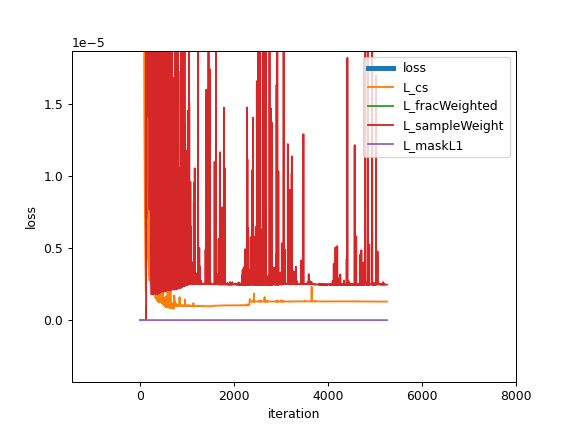

In [408]:
crc.plot_loss()

In [383]:
gc.collect()

torch.cuda.empty_cache()

gc.collect()

torch.cuda.empty_cache()

<IPython.core.display.Javascript object>


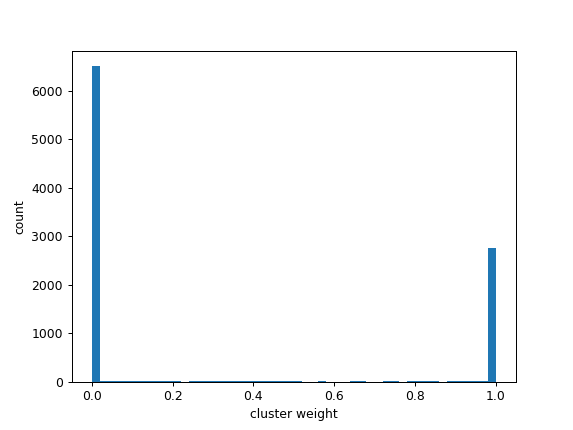

In [384]:
crc.plot_clusterWeights()

<IPython.core.display.Javascript object>


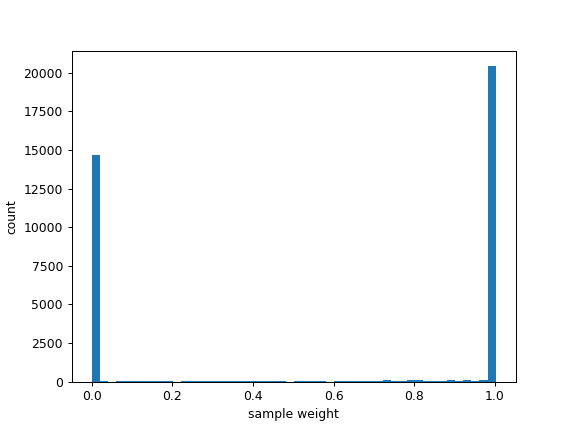

In [385]:
crc.plot_sampleWeights()

In [386]:
m_threshold=0.9

preds, confidence, cIdx_preds = crc.predict(m_threshold=m_threshold)

In [387]:
cIdx_preds.shape

torch.Size([2819])

<IPython.core.display.Javascript object>


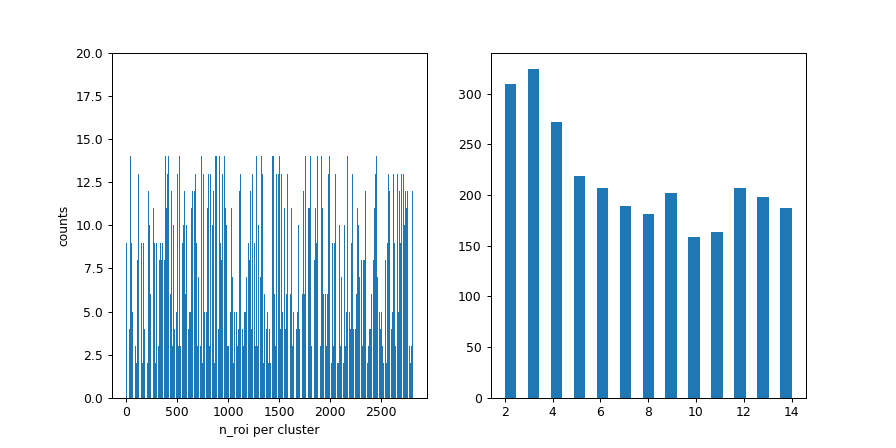

(0.0, 20.0)

In [388]:
fig, axs = crc.plot_labelCounts()
axs[0].set_ylim([0,20])

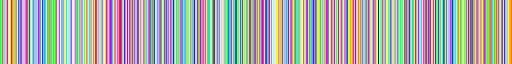

In [389]:
cmap = plotting_helpers.rand_cmap(nlabels=int(preds.max()), under=[0,0,0,0.0], verbose=False);
cmap

<IPython.core.display.Javascript object>


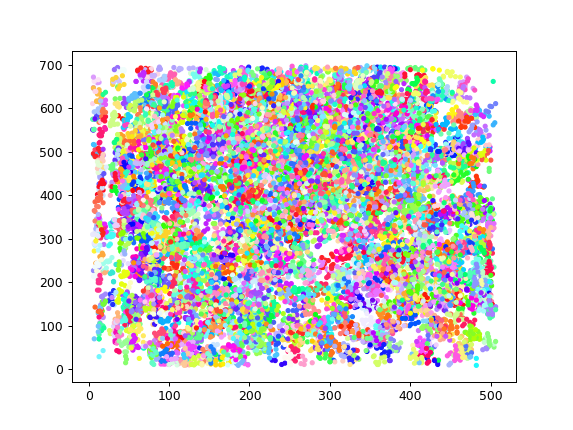

In [390]:
colors = cmap(preds / preds.max())
colors[...,:3] = colors[...,:3] * confidence.numpy()[:,None]

plt.figure()
plt.scatter(meds[:,0], meds[:,1], s=10, c=colors)

<IPython.core.display.Javascript object>


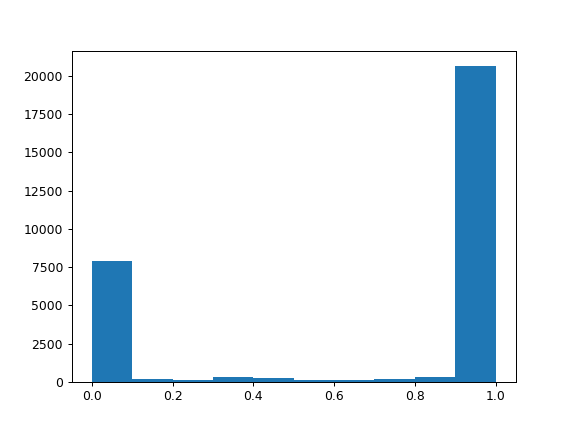

In [391]:
plt.figure()
plt.hist(confidence);

<IPython.core.display.Javascript object>


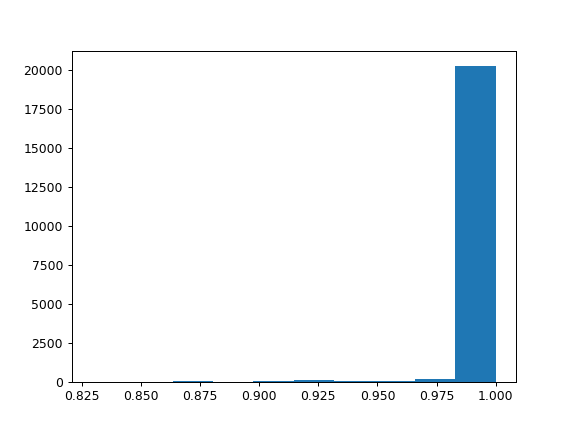

In [392]:
plt.figure()
plt.hist(confidence[preds>=0]);

# Colored clusters image
make an animation loop of an entire FOV looping through each session with all the ROIs. \
Each ROI in a cluster is given a distinct cluster color

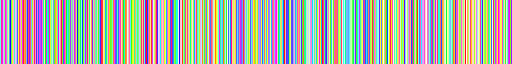

In [393]:
cmap = plotting_helpers.rand_cmap(nlabels=int(preds.max()), under=[0,0,0,0.0], verbose=False);
cmap

In [394]:
idx_roi_cat = np.concatenate([np.arange(sfs.shape[0]) for sfs in ROIs_aligned]) # indices of each ROI concatenated together
idx_roi_session = np.concatenate([np.ones(sfs.shape[0])*ii for ii,sfs in enumerate(ROIs_aligned)])

In [395]:
n_planes = n_sessions
labels = classification.squeeze_integers(preds.numpy().astype(np.int64))

labels[(confidence < 0.5).numpy()] = -1
# labels = labels

ucid_toUse = labels
idx_roi_session_toUse = idx_roi_session

cmaps = sparse.COO(rand_cmap(len(np.unique(ucid_toUse)), verbose=False)(np.int64(ucid_toUse))[:,:3])
plane_oneHot = classification.idx_to_oneHot(idx_roi_session_toUse.astype(np.int32))

ROIs_csr = scipy.sparse.csr_matrix(scipy.sparse.vstack(ROIs_aligned))
ROIs_csr_scaled = ROIs_csr.multiply(ROIs_csr.max(1).power(-1))
ROIs_sCOO = sparse.COO(ROIs_csr_scaled)

def tile_sparse(arr, n_tiles):
    """
    tiles along new (last) dimension
    """
    out = sparse.stack([arr for _ in range(n_tiles)], axis=-1)
    return out

ROIs_tiled = tile_sparse(tile_sparse(ROIs_sCOO, n_planes), 3)

ROIs_colored = ROIs_tiled * cmaps[:,None,None,:] * plane_oneHot[:,None,:,None]

FOV_ROIs_colored = ROIs_colored.sum(0).reshape((frame_height, frame_width, n_planes, 3)).transpose((2,0,1,3))

In [396]:
FOV_all_noClip = copy.copy(FOV_ROIs_colored.todense())
FOV_all_noClip[FOV_all_noClip>1] = 1

In [239]:
image_processing.play_video_cv2(FOV_all_noClip*255, frameRate=3, 
#                                 save_path='/media/rich/bigSSD/analysis_data/mouse 2_6/multiday_alignment/run_20220403/run_liberal_4to9Sesh.avi'
                           )

  0%|          | 0/14 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


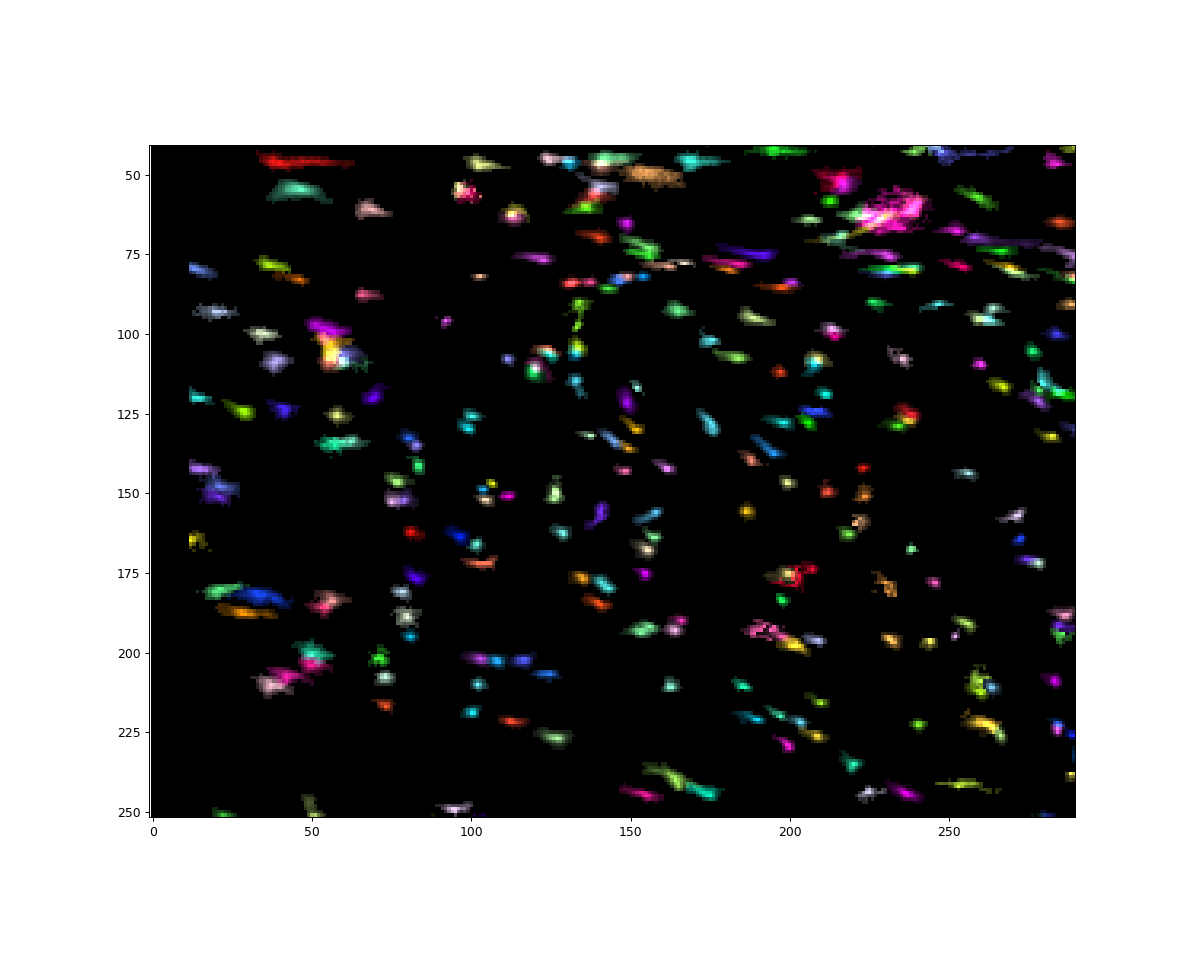

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

In [397]:
%matplotlib notebook
from ipywidgets import *

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
imshow_FOV = ax.imshow(FOV_all_noClip[0], interpolation='none')

def update(i_frame = 0):
    fig.canvas.draw_idle()
    imshow_FOV.set_data(FOV_all_noClip[i_frame])


interact(update, i_frame=widgets.IntSlider(min=0, max=FOV_all_noClip.shape[0]-1, step=1, value=0));

<IPython.core.display.Javascript object>


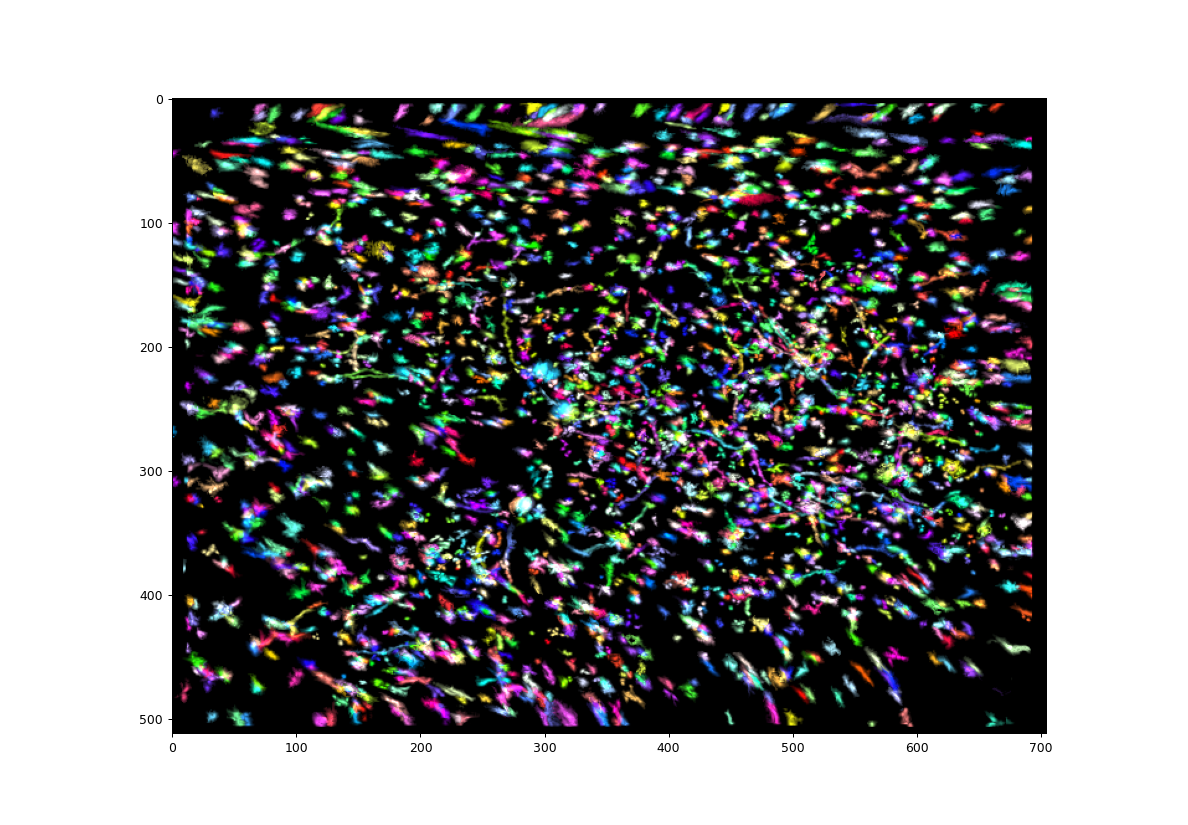

In [398]:
plt.figure()
plt.imshow(FOV_all_noClip.max(0))

outputs:
`UCIDs`
`UCIDs_bySession`

In [86]:
## Only need to run this once since it is just pulling from stuff that should be static

ROIs_raw = scipy.sparse.vstack([scipy.sparse.csr_matrix(rois.reshape(rois.shape[0], -1)) for rois in tqdm(sf_all)])

ROIs = {
    "ROIs_aligned": ROIs_aligned,
    "ROIs_raw": ROIs_raw,
    "frame_height": frame_height,
    "frame_width": frame_width,
    "idx_roi_session": idx_roi_session
}

  0%|          | 0/14 [00:00<?, ?it/s]

In [87]:
name_save = os.path.split(dir_allOuterFolders)[-1]

In [88]:
dir_save = Path(r'/media/rich/bigSSD/analysis_data/ROI_tracking/Valerio/4th_email/results/').resolve()

In [89]:
pickle_helpers.simple_save(
    {
        "UCIDs": UCIDs,
        "UCIDs_bySession": UCIDs_bySession,
        "ROIs": ROIs
    },
    filename=dir_save / (name_save + '.plane0.anySize' '.pkl'
#     filename='/media/rich/bigSSD/analysis_data/mouse 2_6/multiday_alignment/UCIDs.pkl'
)